# Evalulated Delta DO and Delta NO3 
### Delta = Scenario - Reference

In [1]:
import sys
import os
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean.cm as cm

## Load shapefile for graphing and define runs to plot up

In [2]:
case = 'main'
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['paths']['shapefile']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)

output_directory = pathlib.Path(
    ssm['paths']['graphics']
)/case/'delta_DO_NO3'

runs = ["wqm_reference","4b","4c","4f"]

# Load min DO across 24-hrs (daily) and depth
Note: This code assumes that the netcdf for these settings were already created with `process_netcdf.py` ([github link](https://github.com/UW-PSI/SalishSeaModel-analysis/blob/main/py_scripts/process_netcdf.py)). 

The **doxg** variable is in an array of **size** (ndays  x nodes) = **(361 x 16012)**.

In [3]:
doxg={}
paths = {}
for run in runs:
    
    paths[run]=pathlib.Path(
        '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/main/DOXG'
    )/run/'wc'/'daily_min_DOXG_wc.nc'
    
    with xarray.open_dataset(paths[run]) as ds:
        param_full=ds[[*ds][0]]
        # Sub-sample nodes (from 16012 nodes to 7494)
        param=param_full[:,:,gdf['tce']-1]
        # Apply "stat_type" across depth levels
        doxg[run] = getattr(np,"min")(param,axis=1)
        # Get number of days and nodes
        [ndays,nlevels,nnodes]=param.shape

### Calculate Delta DO (Scenario - Reference)

In [4]:
delta_do = {}
for run in runs:
    delta_do[run]=doxg[run] - doxg['wqm_reference']


# Load mean, surface NO3 across 24-hrs (daily) 
Note: This code assumes that the netcdf for these settings were already created with `process_netcdf.py` ([github link](https://github.com/UW-PSI/SalishSeaModel-analysis/blob/main/py_scripts/process_netcdf.py)).

The **no3** variables is in an array of **size** (ndays x nodes) = **(361 x 16012)**.

In [5]:
no3={}
paths = {}
for run in runs:
    
    paths[run]=pathlib.Path(
        '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/main/NO3'
    )/run/'surface'/'daily_mean_NO3_surface.nc'
    
    with xarray.open_dataset(paths[run]) as ds:
        param_full=ds[[*ds][0]]
        # Sub-sample nodes (from 16012 nodes to 7494)
        no3[run]=param_full[:,gdf['tce']-1]
        # Get number of days and nodes
        [ndays,nnodes]=no3[run].shape
        
no3[run].shape

(361, 16012)

### Calculate Delta NO3 (Scenario - Reference)

In [6]:
delta_no3 = {}
for run in runs:
    delta_no3[run]=no3[run] - no3['wqm_reference']

# Plot Delta DO
- Need to specify plot `day` (e.g. day = 239)

Day 244 of 361
Day 244 of 361
Day 244 of 361


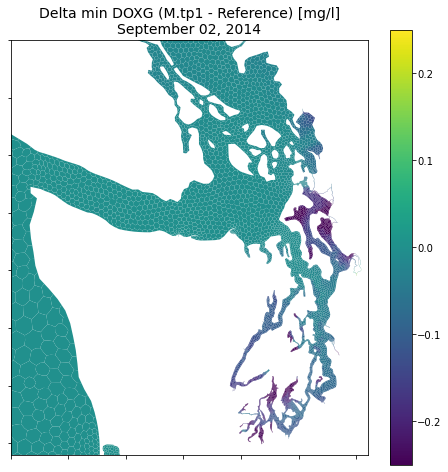

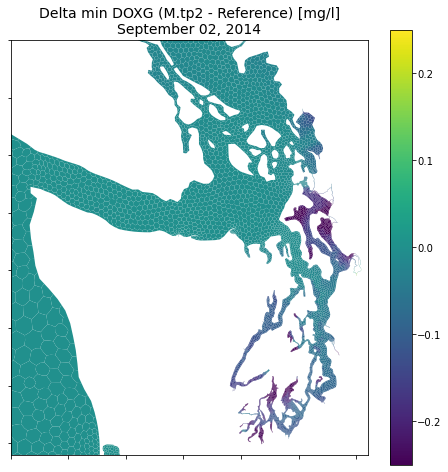

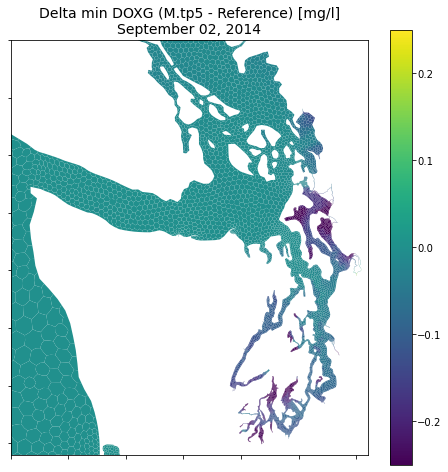

In [7]:
# select day for plotting
day = 239
model_var = 'DOXG'
# hard-code date period
dti = pandas.date_range("2014-01-01", periods=367, freq="D")

model_day = day + ssm['run_information']['spin_up_days'] 
# date to show in graphic title
model_date = dti[model_day]
for run_tag in ['4b','4c', '4f']:

    # define output file name with model day-of-year
    output_file = output_directory/f'{case}_{run_tag}_Delta_{model_var}_{model_day+1}.png'

    print(f'Day {model_day} of {ndays}')
    gdf[model_var] = delta_do[run_tag][day,:]

    # Set graphic fontsizes
    mpl.rc('font', size=10)
    # some of the following may be repetetive but can also be set 
    # relative to the font value above (eg "xx-small, x-small,small, 
    # medium, large, x-large, xx-large, larger, or smaller")
    mpl.rc('legend', fontsize=10)
    mpl.rc('axes', titlesize=14)
    mpl.rc('axes', labelsize=10)
    mpl.rc('figure', titlesize=10)
    mpl.rc('font', family='sans-serif', weight='normal', style='normal')

    fig, axs = plt.subplots(1, figsize = (8,8))
    gdf.plot(ax=axs,
       column=model_var,
       legend=True,
       vmin = -0.25,
       vmax = 0.25
    )
    # set graphic limits (these capture the range where DO_standard applies)
    axs.set_xlim(-1.39e7,-1.359e7)
    axs.set_ylim(5.94e6,6.3e6)
    # remove x-, y-labels
    axs.set_xticklabels('')
    axs.set_yticklabels('')
    # add background landscape
    # cx.add_basemap(axs, 
    #     crs=gdf.crs,
    #     source=cx.providers.Stamen.TerrainBackground,
    #     alpha=1
    # )
    title_tag = f"Delta min {model_var} ({ssm['run_information']['run_tag']['main'][run_tag]} - Reference) [mg/l]"
    axs.set_title(
        f"{title_tag}\n{model_date.month_name()} {model_date.day:02d}, 2014"
    )
    plt.savefig(output_file, bbox_inches='tight', format='png')

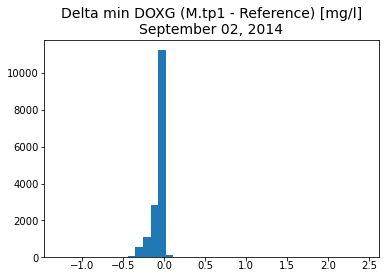

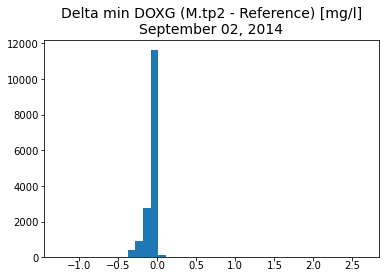

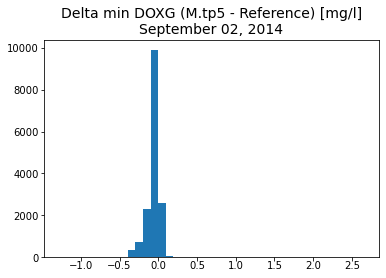

In [12]:
for run in ['4b','4c', '4f']:
    fig, axs = plt.subplots(1, figsize = (6,4))
    axs.hist(delta_do[run][day,:],40)
    title_tag = f"Delta min DOXG ({ssm['run_information']['run_tag']['main'][run]} - Reference) [mg/l]"
    axs.set_title(
        f"{title_tag}\n{model_date.month_name()} {model_date.day:02d}, 2014"
    )